# Collaboration and Competition Project

## Section 1: Setup and Imports

This section installs and verifies dependencies like PyTorch and Protocol Buffers, then imports libraries for numerical operations, deep learning, and data management. It prepares the environment for building and training a machine learning model in a Unity-based simulation.

In [1]:
!pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /workspace/home/python
  Preparing metadata (setup.py) ... done


  Created wheel for unityagents: filename=unityagents-0.4.0-py3-none-any.whl size=71615 sha256=b060a4e08a9363ee1028be7ceff6ed64cdf3798d8f55dccd75f2df36dabdf67f
  Stored in directory: /tmp/pip-ephem-wheel-cache-688btva3/wheels/7a/40/00/46cdf9603f1faf1c020d0c841b78009acc81cf9b5d130b0fc3
Successfully built unityagents
  Attempting uninstall: unityagents
    Found existing installation: unityagents 0.4.0
    Uninstalling unityagents-0.4.0:
      Successfully uninstalled unityagents-0.4.0

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!pip install protobuf==3.20.3

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Restart the Kernel

Restart the Kernel, and verify the protobuf version.

In [4]:
import google.protobuf
print(google.protobuf.__version__)

3.20.3


In [5]:
# Import Libraries
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random
import copy
import matplotlib.pyplot as plt
import time

## Section 2: Initialize environment

Initialize the Unity Tennis environment and extracts key parameters like state and action sizes for the agents.

In [6]:
# Initialize the Tennis environment
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# Get the default brain (control interface)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment to get initial observations
env_info = env.reset(train_mode=True)[brain_name]

# Extract environment parameters
num_agents = len(env_info.agents)  # Number of agents (2)
action_size = brain.vector_action_space_size  # Size of action space per agent
states = env_info.vector_observations  # State observations for all agents
state_size = states.shape[1]  # Size of state space per agent

# Print environment details
print(f"Number of agents: {num_agents}")
print(f"Size of each action: {action_size}")
print(f"There are {states.shape[0]} agents. Each observes a state with length: {state_size}")
print(f"The state for the first agent looks like: {states[0]}")

Found path: /data/Tennis_Linux_NoVis/Tennis.x86_64
Mono path[0] = '/data/Tennis_Linux_NoVis/Tennis_Data/Managed'
Mono config path = '/data/Tennis_Linux_NoVis/Tennis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Section 3: State and Action Space Explanation

The Tennis environment features two agents, each tasked with controlling a racket to hit a ball over a net. The objective is to keep the ball in play, with rewards given for successful hits and penalties applied for misses.

**State Space**
- **Dimension**: Each agent observes a state represented by a 24-dimensional vector.

- **Description**: The state captures key information about the environment, including:
    - The position and velocity of the ball.

    - The position and velocity of the agent's own racket.

    - Additional environmental factors, such as the net's position.

- **Observation**: Each agent receives a unique local observation, tailored to its perspective, though both agents operate within the same shared environment.

- **Format**: The state is a continuous vector of 24 numerical values, providing a detailed snapshot of the game at each timestep.

**Action Space**
- **Dimension**: Each agent operates in a 2-dimensional continuous action space.

- **Description**: The actions allow the agent to:
    - Move toward or away from the net.
    - Jump to strike the ball.

- **Range**: Action values are continuous and bounded between -1 and 1:
    - A value of -1 might indicate maximum movement in one direction (e.g., moving backward).
    - A value of +1 might indicate maximum movement in the opposite direction (e.g., moving forward).

- **Control**: Success in the environment requires the agents to coordinate their movements, balancing collaboration and competition to keep the ball in play.

## Section 4: Neural Network Architectures

Defines the Actor and Critic neural networks used by each agent. The Actor maps states to actions, while the Critic estimates Q-values based on states and actions.

In [7]:
def hidden_init(layer):
    """Initialize weights for hidden layers."""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor network mapping states to actions."""
    def __init__(self, state_size, action_size, seed=0, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize network weights."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Forward pass: state -> action."""
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic network estimating Q-values from states and actions."""
    def __init__(self, full_state_size, actions_size, seed=0, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + actions_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize network weights."""
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Forward pass: (state, action) -> Q-value."""
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Section 5: Replay Buffer

Implements a replay buffer to store experiences (states, actions, rewards, etc.) and sample them randomly for training.

In [8]:
BUFFER_SIZE = int(1e5)  # Maximum replay buffer size
BATCH_SIZE = 256        # Batch size for training

class ReplayBuffer:
    """Buffer to store and sample agent experiences."""
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'full_state', 'action', 'reward', 'next_state', 'next_full_state', 'done'])
        random.seed(seed)

    def add(self, state, full_state, action, reward, next_state, next_full_state, done):
        """Add an experience to the buffer."""
        e = self.experience(state, full_state, action, reward, next_state, next_full_state, done)
        self.memory.append(e)

    def sample(self):
        """Sample a batch of experiences."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().to(device)
        full_states = torch.from_numpy(np.array([e.full_state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences])).float().to(device)
        next_full_states = torch.from_numpy(np.array([e.next_full_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, full_states, actions, rewards, next_states, next_full_states, dones)

    def __len__(self):
        """Return current buffer size."""
        return len(self.memory)

## Section 6: MADDPG Agent

Defines the MADDPG class, which coordinates multiple agents, manages their actions, and triggers learning from the shared replay buffer.

In [9]:
GAMMA = 0.99  # Discount factor
TAU = 1e-3    # Soft update parameter
UPDATE_FREQ = 1  # Frequency of learning updates

class MADDPG:
    """Multi-Agent DDPG managing multiple agents."""
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(random_seed)
        self.agents = [Agent(state_size, action_size, num_agents, random_seed) for _ in range(num_agents)]
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.step_count = 0

    def reset(self):
        """Reset noise for all agents."""
        for agent in self.agents:
            agent.reset()

    def act(self, state, i_episode, add_noise=True):
        """Generate actions for all agents given their states."""
        actions = [agent.act(agent_state, i_episode, add_noise) for agent_state, agent in zip(state, self.agents)]
        flat_actions = np.concatenate(actions).tolist()
        return flat_actions

    def step(self, i_episode, state, action, reward, next_state, done):
        """Store experience and trigger learning."""
        full_state = np.reshape(state, newshape=(-1))
        next_full_state = np.reshape(next_state, newshape=(-1))
        self.memory.add(state, full_state, action, reward, next_state, next_full_state, done)
        self.step_count = (self.step_count + 1) % UPDATE_FREQ
        if len(self.memory) > BATCH_SIZE and i_episode > 500:
            for _ in range(3):  # Multiple updates per step
                for agent in self.agents:
                    experiences = self.memory.sample()
                    self.learn(experiences, agent, GAMMA)
                for agent in self.agents:
                    agent.soft_update(agent.actor_local, agent.actor_target, TAU)
                    agent.soft_update(agent.critic_local, agent.critic_target, TAU)

    def learn(self, experiences, agent, gamma):
        """Perform learning update for a specific agent."""
        states, full_states, actions, rewards, next_states, next_full_states, dones = experiences
        actor_target_actions = torch.zeros(actions.shape, dtype=torch.float, device=device)
        for agent_idx, agent_i in enumerate(self.agents):
            if agent == agent_i:
                agent_id = agent_idx
            agent_i_current_state = states[:, agent_idx]
            actor_target_actions[:, agent_idx, :] = agent_i.actor_target.forward(agent_i_current_state)
        actor_target_actions = actor_target_actions.view(BATCH_SIZE, -1)
        agent_state = states[:, agent_id, :]
        agent_action = actions[:, agent_id, :]
        agent_reward = rewards[:, agent_id].view(-1, 1)
        agent_done = dones[:, agent_id].view(-1, 1)
        actor_local_actions = actions.clone()
        actor_local_actions[:, agent_id, :] = agent.actor_local.forward(agent_state)
        actor_local_actions = actor_local_actions.view(BATCH_SIZE, -1)
        actions = actions.view(BATCH_SIZE, -1)
        agent_experience = (full_states, actions, actor_local_actions, actor_target_actions,
                            agent_state, agent_action, agent_reward, agent_done,
                            next_states, next_full_states)
        agent.learn(agent_experience, gamma)

    def save(self):
        """Save model weights for all agents."""
        for idx, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), f'checkpoint_agent{idx}_actor.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_agent{idx}_critic.pth')



## Section 7: Single Agent Class

Defines the individual Agent class, including its actor and critic networks, noise process, and learning logic.

In [10]:
LR_ACTOR = 1e-4  # Actor learning rate
LR_CRITIC = 3e-4  # Critic learning rate
WEIGHT_DECAY = 0  # L2 weight decay
NOISE_REDUCTION_RATE = 0.99  # Noise decay rate
EPISODES_BEFORE_TRAINING = 500  # Episodes before reducing noise
NOISE_START = 1.0  # Initial noise scale
NOISE_END = 0.1  # Minimum noise scale

class Agent:
    """Single agent with actor-critic architecture."""
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(random_seed)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.critic_local = Critic(state_size * num_agents, action_size * num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size * num_agents, action_size * num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.soft_update(self.actor_local, self.actor_target, 1)  # Full copy for initialization
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.noise = OUNoise(action_size, random_seed)
        self.noise_reduction_ratio = NOISE_START

    def act(self, state, i_episode, add_noise=True):
        """Generate action for a given state."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            if i_episode > EPISODES_BEFORE_TRAINING and self.noise_reduction_ratio > NOISE_END:
                self.noise_reduction_ratio = NOISE_REDUCTION_RATE ** (i_episode - EPISODES_BEFORE_TRAINING)
            action += self.noise_reduction_ratio * self.add_noise2()
        return np.clip(action, -1, 1)

    def add_noise2(self):
        """Add Gaussian noise for exploration."""
        return 0.5 * np.random.standard_normal(self.action_size)

    def reset(self):
        """Reset noise process."""
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update actor and critic networks."""
        full_states, actions, actor_local_actions, actor_target_actions, _, _, agent_reward, agent_done, _, next_full_states = experiences
        Q_targets_next = self.critic_target(next_full_states, actor_target_actions)
        Q_targets = agent_reward + (gamma * Q_targets_next * (1 - agent_done))
        Q_expected = self.critic_local(full_states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        actor_loss = -self.critic_local(full_states, actor_local_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def soft_update(self, local_model, target_model, tau):
        """Soft update target network parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck noise process for exploration."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset noise state to mean."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Generate noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## Section 8: Training Loop

Implements the training loop, where agents interact with the environment, learn, and save weights when the success criterion is met. A plot of scores is generated and saved.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
maddpg = MADDPG(state_size, action_size, num_agents, 1976)

In [13]:
scores_max_hist = []
scores_mean_hist = []

def maddpg_train(n_episodes=3000):
    """Train the MADDPG agents."""
    scores_deque = deque(maxlen=100)
    solved = False

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg.reset()
        start_time = time.time()

        while True:
            action = maddpg.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            scores += reward
            maddpg.step(i_episode, state, action, reward, next_state, done)
            if np.any(done):
                break
            state = next_state

        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)
        duration = time.time() - start_time

        print(f"Episode {i_episode}\tAvg Score: {score_mean:.5f}\tMax Score: {score_max:.5f}\tTime: {duration:.2f}")

        if not solved and score_mean >= 0.5:
            print(f"\nEnvironment solved in {i_episode} episodes with average score {score_mean:.5f}\n")
            maddpg.save()
            solved = True

        if i_episode % 500 == 0:
            print(f"Episode {i_episode}\tAvg Score: {score_mean:.5f}\tMax Score: {score_max:.5f}\tTime: {duration:.2f}")







In [14]:
# Train the agents
maddpg_train()

Episode 1	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.48
Episode 2	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.32
Episode 3	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.31
Episode 4	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.31
Episode 5	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.31
Episode 6	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.39
Episode 7	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.39
Episode 8	Avg Score: 0.00000	Max Score: 0.00000	Time: 0.31
Episode 9	Avg Score: 0.01000	Max Score: 0.09000	Time: 0.70
Episode 10	Avg Score: 0.00900	Max Score: 0.00000	Time: 0.32
Episode 11	Avg Score: 0.00818	Max Score: 0.00000	Time: 0.38
Episode 12	Avg Score: 0.00750	Max Score: 0.00000	Time: 0.30
Episode 13	Avg Score: 0.01385	Max Score: 0.09000	Time: 0.71
Episode 14	Avg Score: 0.01286	Max Score: 0.00000	Time: 0.38
Episode 15	Avg Score: 0.01200	Max Score: 0.00000	Time: 0.39
Episode 16	Avg Score: 0.01125	Max Score: 0.00000	Time: 0.41
Episode 17	Avg Score: 0.01059	Max Score: 0.00000	

Episode 138	Avg Score: 0.02580	Max Score: 0.10000	Time: 0.80
Episode 139	Avg Score: 0.02490	Max Score: 0.00000	Time: 0.31
Episode 140	Avg Score: 0.02400	Max Score: 0.00000	Time: 0.38
Episode 141	Avg Score: 0.02400	Max Score: 0.00000	Time: 0.31
Episode 142	Avg Score: 0.02400	Max Score: 0.00000	Time: 0.31
Episode 143	Avg Score: 0.02490	Max Score: 0.09000	Time: 0.79
Episode 144	Avg Score: 0.02490	Max Score: 0.00000	Time: 0.31
Episode 145	Avg Score: 0.02490	Max Score: 0.00000	Time: 0.38
Episode 146	Avg Score: 0.02590	Max Score: 0.10000	Time: 0.79
Episode 147	Avg Score: 0.02590	Max Score: 0.00000	Time: 0.39
Episode 148	Avg Score: 0.02690	Max Score: 0.10000	Time: 0.81
Episode 149	Avg Score: 0.02790	Max Score: 0.10000	Time: 1.20
Episode 150	Avg Score: 0.02790	Max Score: 0.00000	Time: 0.38
Episode 151	Avg Score: 0.02790	Max Score: 0.00000	Time: 0.31
Episode 152	Avg Score: 0.02890	Max Score: 0.10000	Time: 1.50
Episode 153	Avg Score: 0.02990	Max Score: 0.10000	Time: 0.70
Episode 154	Avg Score: 0

Episode 273	Avg Score: 0.02320	Max Score: 0.00000	Time: 0.30
Episode 274	Avg Score: 0.02320	Max Score: 0.00000	Time: 0.38
Episode 275	Avg Score: 0.02320	Max Score: 0.00000	Time: 0.32
Episode 276	Avg Score: 0.02320	Max Score: 0.00000	Time: 0.31
Episode 277	Avg Score: 0.02220	Max Score: 0.00000	Time: 0.30
Episode 278	Avg Score: 0.02220	Max Score: 0.00000	Time: 0.39
Episode 279	Avg Score: 0.02220	Max Score: 0.00000	Time: 0.41
Episode 280	Avg Score: 0.02220	Max Score: 0.00000	Time: 0.38
Episode 281	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.31
Episode 282	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.38
Episode 283	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.31
Episode 284	Avg Score: 0.02230	Max Score: 0.10000	Time: 0.49
Episode 285	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.31
Episode 286	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.38
Episode 287	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.31
Episode 288	Avg Score: 0.02130	Max Score: 0.00000	Time: 0.38
Episode 289	Avg Score: 0

Episode 408	Avg Score: 0.01380	Max Score: 0.00000	Time: 0.32
Episode 409	Avg Score: 0.01380	Max Score: 0.00000	Time: 0.30
Episode 410	Avg Score: 0.01380	Max Score: 0.00000	Time: 0.31
Episode 411	Avg Score: 0.01380	Max Score: 0.00000	Time: 0.31
Episode 412	Avg Score: 0.01470	Max Score: 0.09000	Time: 0.70
Episode 413	Avg Score: 0.01470	Max Score: 0.00000	Time: 0.39
Episode 414	Avg Score: 0.01470	Max Score: 0.00000	Time: 0.31
Episode 415	Avg Score: 0.01470	Max Score: 0.00000	Time: 0.38
Episode 416	Avg Score: 0.01370	Max Score: 0.00000	Time: 0.31
Episode 417	Avg Score: 0.01380	Max Score: 0.10000	Time: 0.79
Episode 418	Avg Score: 0.01480	Max Score: 0.10000	Time: 1.12
Episode 419	Avg Score: 0.01480	Max Score: 0.00000	Time: 0.41
Episode 420	Avg Score: 0.01480	Max Score: 0.00000	Time: 0.30
Episode 421	Avg Score: 0.01480	Max Score: 0.00000	Time: 0.30
Episode 422	Avg Score: 0.01380	Max Score: 0.00000	Time: 0.30
Episode 423	Avg Score: 0.01480	Max Score: 0.10000	Time: 0.79
Episode 424	Avg Score: 0

Episode 542	Avg Score: 0.01370	Max Score: 0.00000	Time: 1.36
Episode 543	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.39
Episode 544	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.36
Episode 545	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.36
Episode 546	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.53
Episode 547	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.36
Episode 548	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.38
Episode 549	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.39
Episode 550	Avg Score: 0.01280	Max Score: 0.00000	Time: 1.38
Episode 551	Avg Score: 0.01180	Max Score: 0.00000	Time: 1.47
Episode 552	Avg Score: 0.01180	Max Score: 0.00000	Time: 1.37
Episode 553	Avg Score: 0.01180	Max Score: 0.00000	Time: 1.40
Episode 554	Avg Score: 0.01080	Max Score: 0.00000	Time: 1.42
Episode 555	Avg Score: 0.01080	Max Score: 0.00000	Time: 1.35
Episode 556	Avg Score: 0.01080	Max Score: 0.00000	Time: 1.52
Episode 557	Avg Score: 0.01080	Max Score: 0.00000	Time: 1.48
Episode 558	Avg Score: 0

Episode 677	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.46
Episode 678	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.34
Episode 679	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.33
Episode 680	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.35
Episode 681	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.32
Episode 682	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.43
Episode 683	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.36
Episode 684	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.33
Episode 685	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.36
Episode 686	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.29
Episode 687	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.40
Episode 688	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.35
Episode 689	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.30
Episode 690	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.33
Episode 691	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.32
Episode 692	Avg Score: 0.00100	Max Score: 0.00000	Time: 1.40
Episode 693	Avg Score: 0

Episode 812	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.38
Episode 813	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.31
Episode 814	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.37
Episode 815	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.35
Episode 816	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.44
Episode 817	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.32
Episode 818	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.38
Episode 819	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.35
Episode 820	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.34
Episode 821	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.46
Episode 822	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.36
Episode 823	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.36
Episode 824	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.33
Episode 825	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.34
Episode 826	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.45
Episode 827	Avg Score: 0.01540	Max Score: 0.00000	Time: 1.34
Episode 828	Avg Score: 0

Episode 947	Avg Score: 0.05440	Max Score: 0.00000	Time: 1.56
Episode 948	Avg Score: 0.05440	Max Score: 0.00000	Time: 1.39
Episode 949	Avg Score: 0.05540	Max Score: 0.10000	Time: 3.13
Episode 950	Avg Score: 0.05640	Max Score: 0.10000	Time: 5.19
Episode 951	Avg Score: 0.05740	Max Score: 0.10000	Time: 3.13
Episode 952	Avg Score: 0.05840	Max Score: 0.10000	Time: 2.93
Episode 953	Avg Score: 0.05840	Max Score: 0.00000	Time: 1.45
Episode 954	Avg Score: 0.05940	Max Score: 0.10000	Time: 2.92
Episode 955	Avg Score: 0.05840	Max Score: 0.00000	Time: 1.48
Episode 956	Avg Score: 0.05940	Max Score: 0.10000	Time: 3.02
Episode 957	Avg Score: 0.05850	Max Score: 0.00000	Time: 1.47
Episode 958	Avg Score: 0.05860	Max Score: 0.10000	Time: 3.13
Episode 959	Avg Score: 0.05950	Max Score: 0.09000	Time: 2.92
Episode 960	Avg Score: 0.06050	Max Score: 0.10000	Time: 5.67
Episode 961	Avg Score: 0.06060	Max Score: 0.10000	Time: 2.80
Episode 962	Avg Score: 0.06270	Max Score: 0.30000	Time: 10.52
Episode 963	Avg Score: 

Episode 1079	Avg Score: 0.07770	Max Score: 0.10000	Time: 5.02
Episode 1080	Avg Score: 0.07670	Max Score: 0.00000	Time: 1.36
Episode 1081	Avg Score: 0.07670	Max Score: 0.00000	Time: 1.33
Episode 1082	Avg Score: 0.07770	Max Score: 0.10000	Time: 3.19
Episode 1083	Avg Score: 0.07770	Max Score: 0.00000	Time: 1.46
Episode 1084	Avg Score: 0.07670	Max Score: 0.00000	Time: 1.39
Episode 1085	Avg Score: 0.07570	Max Score: 0.00000	Time: 2.55
Episode 1086	Avg Score: 0.07560	Max Score: 0.09000	Time: 3.07
Episode 1087	Avg Score: 0.07660	Max Score: 0.10000	Time: 2.98
Episode 1088	Avg Score: 0.07660	Max Score: 0.10000	Time: 3.27
Episode 1089	Avg Score: 0.07660	Max Score: 0.10000	Time: 3.13
Episode 1090	Avg Score: 0.07760	Max Score: 0.10000	Time: 2.99
Episode 1091	Avg Score: 0.07760	Max Score: 0.10000	Time: 3.12
Episode 1092	Avg Score: 0.07760	Max Score: 0.10000	Time: 2.90
Episode 1093	Avg Score: 0.07760	Max Score: 0.10000	Time: 3.20
Episode 1094	Avg Score: 0.07860	Max Score: 0.10000	Time: 3.16
Episode 

Episode 1212	Avg Score: 0.07520	Max Score: 0.10000	Time: 2.97
Episode 1213	Avg Score: 0.07420	Max Score: 0.00000	Time: 1.25
Episode 1214	Avg Score: 0.07330	Max Score: 0.00000	Time: 1.28
Episode 1215	Avg Score: 0.07330	Max Score: 0.10000	Time: 5.08
Episode 1216	Avg Score: 0.07430	Max Score: 0.20000	Time: 6.83
Episode 1217	Avg Score: 0.07430	Max Score: 0.10000	Time: 2.97
Episode 1218	Avg Score: 0.07520	Max Score: 0.09000	Time: 2.42
Episode 1219	Avg Score: 0.07520	Max Score: 0.10000	Time: 2.89
Episode 1220	Avg Score: 0.07420	Max Score: 0.00000	Time: 1.35
Episode 1221	Avg Score: 0.07420	Max Score: 0.10000	Time: 2.89
Episode 1222	Avg Score: 0.07520	Max Score: 0.10000	Time: 3.17
Episode 1223	Avg Score: 0.07620	Max Score: 0.10000	Time: 5.04
Episode 1224	Avg Score: 0.07520	Max Score: 0.00000	Time: 1.33
Episode 1225	Avg Score: 0.07420	Max Score: 0.00000	Time: 1.31
Episode 1226	Avg Score: 0.07420	Max Score: 0.10000	Time: 3.11
Episode 1227	Avg Score: 0.07330	Max Score: 0.00000	Time: 1.34
Episode 

Episode 1345	Avg Score: 0.05620	Max Score: 0.10000	Time: 5.10
Episode 1346	Avg Score: 0.05420	Max Score: 0.00000	Time: 1.35
Episode 1347	Avg Score: 0.05320	Max Score: 0.00000	Time: 1.43
Episode 1348	Avg Score: 0.05420	Max Score: 0.10000	Time: 3.27
Episode 1349	Avg Score: 0.05420	Max Score: 0.00000	Time: 1.37
Episode 1350	Avg Score: 0.05320	Max Score: 0.00000	Time: 1.34
Episode 1351	Avg Score: 0.05320	Max Score: 0.00000	Time: 1.45
Episode 1352	Avg Score: 0.05320	Max Score: 0.10000	Time: 4.79
Episode 1353	Avg Score: 0.05320	Max Score: 0.10000	Time: 4.90
Episode 1354	Avg Score: 0.05220	Max Score: 0.00000	Time: 1.46
Episode 1355	Avg Score: 0.05130	Max Score: 0.00000	Time: 1.35
Episode 1356	Avg Score: 0.04930	Max Score: 0.00000	Time: 1.34
Episode 1357	Avg Score: 0.05030	Max Score: 0.10000	Time: 2.96
Episode 1358	Avg Score: 0.05030	Max Score: 0.00000	Time: 1.39
Episode 1359	Avg Score: 0.04830	Max Score: 0.00000	Time: 1.40
Episode 1360	Avg Score: 0.04930	Max Score: 0.20000	Time: 6.93
Episode 

Episode 1478	Avg Score: 0.04850	Max Score: 0.00000	Time: 1.37
Episode 1479	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.37
Episode 1480	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.34
Episode 1481	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.47
Episode 1482	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.34
Episode 1483	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.37
Episode 1484	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.36
Episode 1485	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.34
Episode 1486	Avg Score: 0.04760	Max Score: 0.00000	Time: 1.45
Episode 1487	Avg Score: 0.04460	Max Score: 0.00000	Time: 1.34
Episode 1488	Avg Score: 0.04460	Max Score: 0.00000	Time: 1.39
Episode 1489	Avg Score: 0.04560	Max Score: 0.10000	Time: 4.76
Episode 1490	Avg Score: 0.04560	Max Score: 0.00000	Time: 1.35
Episode 1491	Avg Score: 0.04560	Max Score: 0.00000	Time: 1.38
Episode 1492	Avg Score: 0.04460	Max Score: 0.00000	Time: 1.37
Episode 1493	Avg Score: 0.04460	Max Score: 0.00000	Time: 1.38
Episode 

Episode 1610	Avg Score: 0.06280	Max Score: 0.09000	Time: 3.00
Episode 1611	Avg Score: 0.06380	Max Score: 0.10000	Time: 3.20
Episode 1612	Avg Score: 0.06380	Max Score: 0.00000	Time: 1.37
Episode 1613	Avg Score: 0.06480	Max Score: 0.10000	Time: 4.70
Episode 1614	Avg Score: 0.06480	Max Score: 0.00000	Time: 1.36
Episode 1615	Avg Score: 0.06370	Max Score: 0.09000	Time: 3.27
Episode 1616	Avg Score: 0.06360	Max Score: 0.09000	Time: 3.19
Episode 1617	Avg Score: 0.06260	Max Score: 0.00000	Time: 1.34
Episode 1618	Avg Score: 0.06160	Max Score: 0.00000	Time: 1.35
Episode 1619	Avg Score: 0.06160	Max Score: 0.10000	Time: 3.20
Episode 1620	Avg Score: 0.05960	Max Score: 0.00000	Time: 1.38
Episode 1621	Avg Score: 0.05860	Max Score: 0.00000	Time: 1.35
Episode 1622	Avg Score: 0.05860	Max Score: 0.00000	Time: 1.38
Episode 1623	Avg Score: 0.06060	Max Score: 0.20000	Time: 8.83
Episode 1624	Avg Score: 0.05960	Max Score: 0.00000	Time: 1.36
Episode 1625	Avg Score: 0.05870	Max Score: 0.00000	Time: 1.46
Episode 

Episode 1743	Avg Score: 0.04920	Max Score: 0.10000	Time: 6.34
Episode 1744	Avg Score: 0.04720	Max Score: 0.00000	Time: 1.25
Episode 1745	Avg Score: 0.04720	Max Score: 0.10000	Time: 4.56
Episode 1746	Avg Score: 0.04720	Max Score: 0.00000	Time: 1.34
Episode 1747	Avg Score: 0.04920	Max Score: 0.20000	Time: 6.84
Episode 1748	Avg Score: 0.04920	Max Score: 0.00000	Time: 1.51
Episode 1749	Avg Score: 0.04920	Max Score: 0.00000	Time: 1.40
Episode 1750	Avg Score: 0.04920	Max Score: 0.10000	Time: 3.01
Episode 1751	Avg Score: 0.04830	Max Score: 0.00000	Time: 1.38
Episode 1752	Avg Score: 0.04730	Max Score: 0.00000	Time: 1.36
Episode 1753	Avg Score: 0.04830	Max Score: 0.10000	Time: 4.54
Episode 1754	Avg Score: 0.04920	Max Score: 0.09000	Time: 3.06
Episode 1755	Avg Score: 0.04920	Max Score: 0.09000	Time: 2.94
Episode 1756	Avg Score: 0.04920	Max Score: 0.10000	Time: 3.12
Episode 1757	Avg Score: 0.04920	Max Score: 0.00000	Time: 1.50
Episode 1758	Avg Score: 0.04920	Max Score: 0.00000	Time: 1.40
Episode 

Episode 1876	Avg Score: 0.03940	Max Score: 0.00000	Time: 1.38
Episode 1877	Avg Score: 0.03840	Max Score: 0.00000	Time: 1.51
Episode 1878	Avg Score: 0.03750	Max Score: 0.00000	Time: 1.40
Episode 1879	Avg Score: 0.03660	Max Score: 0.00000	Time: 1.40
Episode 1880	Avg Score: 0.03760	Max Score: 0.10000	Time: 3.10
Episode 1881	Avg Score: 0.03670	Max Score: 0.00000	Time: 1.46
Episode 1882	Avg Score: 0.03570	Max Score: 0.00000	Time: 1.75
Episode 1883	Avg Score: 0.03480	Max Score: 0.00000	Time: 1.76
Episode 1884	Avg Score: 0.03580	Max Score: 0.10000	Time: 3.15
Episode 1885	Avg Score: 0.03590	Max Score: 0.10000	Time: 3.01
Episode 1886	Avg Score: 0.03590	Max Score: 0.10000	Time: 2.88
Episode 1887	Avg Score: 0.03690	Max Score: 0.10000	Time: 2.85
Episode 1888	Avg Score: 0.03790	Max Score: 0.10000	Time: 3.17
Episode 1889	Avg Score: 0.03790	Max Score: 0.00000	Time: 1.37
Episode 1890	Avg Score: 0.03800	Max Score: 0.10000	Time: 2.99
Episode 1891	Avg Score: 0.03900	Max Score: 0.10000	Time: 2.86
Episode 

Episode 2008	Avg Score: 0.08780	Max Score: 0.00000	Time: 1.49
Episode 2009	Avg Score: 0.08780	Max Score: 0.10000	Time: 4.51
Episode 2010	Avg Score: 0.08880	Max Score: 0.20000	Time: 6.27
Episode 2011	Avg Score: 0.08880	Max Score: 0.09000	Time: 3.12
Episode 2012	Avg Score: 0.08890	Max Score: 0.10000	Time: 3.06
Episode 2013	Avg Score: 0.08890	Max Score: 0.10000	Time: 2.89
Episode 2014	Avg Score: 0.08890	Max Score: 0.10000	Time: 4.89
Episode 2015	Avg Score: 0.08790	Max Score: 0.00000	Time: 1.41
Episode 2016	Avg Score: 0.08800	Max Score: 0.10000	Time: 5.14
Episode 2017	Avg Score: 0.08900	Max Score: 0.10000	Time: 3.25
Episode 2018	Avg Score: 0.08700	Max Score: 0.00000	Time: 1.37
Episode 2019	Avg Score: 0.08810	Max Score: 0.20000	Time: 8.72
Episode 2020	Avg Score: 0.08820	Max Score: 0.10000	Time: 3.21
Episode 2021	Avg Score: 0.08820	Max Score: 0.10000	Time: 3.47
Episode 2022	Avg Score: 0.09420	Max Score: 0.70000	Time: 31.66
Episode 2023	Avg Score: 0.09630	Max Score: 0.30000	Time: 13.10
Episod

Episode 2140	Avg Score: 0.18670	Max Score: 0.30000	Time: 12.42
Episode 2141	Avg Score: 0.18660	Max Score: 0.09000	Time: 2.85
Episode 2142	Avg Score: 0.18560	Max Score: 0.00000	Time: 1.61
Episode 2143	Avg Score: 0.18550	Max Score: 0.09000	Time: 3.10
Episode 2144	Avg Score: 0.19150	Max Score: 0.70000	Time: 27.33
Episode 2145	Avg Score: 0.19150	Max Score: 0.10000	Time: 2.89
Episode 2146	Avg Score: 0.19150	Max Score: 0.10000	Time: 3.00
Episode 2147	Avg Score: 0.19140	Max Score: 0.09000	Time: 3.05
Episode 2148	Avg Score: 0.19740	Max Score: 0.70000	Time: 27.20
Episode 2149	Avg Score: 0.19740	Max Score: 0.10000	Time: 2.95
Episode 2150	Avg Score: 0.20950	Max Score: 1.30000	Time: 47.99
Episode 2151	Avg Score: 0.21150	Max Score: 0.50000	Time: 19.83
Episode 2152	Avg Score: 0.21150	Max Score: 0.10000	Time: 5.07
Episode 2153	Avg Score: 0.21360	Max Score: 0.30000	Time: 10.61
Episode 2154	Avg Score: 0.21260	Max Score: 0.10000	Time: 3.34
Episode 2155	Avg Score: 0.21760	Max Score: 0.60000	Time: 23.23
E

Episode 2272	Avg Score: 0.37110	Max Score: 0.90000	Time: 36.22
Episode 2273	Avg Score: 0.37510	Max Score: 0.50000	Time: 21.68
Episode 2274	Avg Score: 0.37710	Max Score: 0.30000	Time: 11.97
Episode 2275	Avg Score: 0.37610	Max Score: 0.10000	Time: 5.08
Episode 2276	Avg Score: 0.37110	Max Score: 0.10000	Time: 5.95
Episode 2277	Avg Score: 0.36510	Max Score: 0.20000	Time: 7.12
Episode 2278	Avg Score: 0.36510	Max Score: 0.20000	Time: 8.50
Episode 2279	Avg Score: 0.35710	Max Score: 0.10000	Time: 5.24
Episode 2280	Avg Score: 0.35700	Max Score: 0.09000	Time: 3.09
Episode 2281	Avg Score: 0.35690	Max Score: 0.09000	Time: 3.03
Episode 2282	Avg Score: 0.35580	Max Score: 0.09000	Time: 3.07
Episode 2283	Avg Score: 0.36170	Max Score: 0.69000	Time: 26.28
Episode 2284	Avg Score: 0.35760	Max Score: 0.09000	Time: 3.12
Episode 2285	Avg Score: 0.35450	Max Score: 0.19000	Time: 6.66
Episode 2286	Avg Score: 0.35450	Max Score: 0.40000	Time: 16.73
Episode 2287	Avg Score: 0.36650	Max Score: 1.40000	Time: 56.82
Ep

Episode 2404	Avg Score: 0.29740	Max Score: 0.20000	Time: 6.72
Episode 2405	Avg Score: 0.28940	Max Score: 0.10000	Time: 3.19
Episode 2406	Avg Score: 0.29740	Max Score: 1.40000	Time: 54.06
Episode 2407	Avg Score: 0.29340	Max Score: 0.10000	Time: 3.20
Episode 2408	Avg Score: 0.28950	Max Score: 0.10000	Time: 6.94
Episode 2409	Avg Score: 0.28750	Max Score: 0.10000	Time: 4.24
Episode 2410	Avg Score: 0.28850	Max Score: 0.30000	Time: 11.16
Episode 2411	Avg Score: 0.28550	Max Score: 0.20000	Time: 8.45
Episode 2412	Avg Score: 0.28640	Max Score: 0.29000	Time: 10.14
Episode 2413	Avg Score: 0.28740	Max Score: 0.20000	Time: 6.43
Episode 2414	Avg Score: 0.28740	Max Score: 0.30000	Time: 14.73
Episode 2415	Avg Score: 0.28550	Max Score: 0.10000	Time: 3.14
Episode 2416	Avg Score: 0.29050	Max Score: 0.60000	Time: 23.01
Episode 2417	Avg Score: 0.29450	Max Score: 0.50000	Time: 20.14
Episode 2418	Avg Score: 0.29450	Max Score: 0.10000	Time: 3.71
Episode 2419	Avg Score: 0.29350	Max Score: 0.10000	Time: 3.18
Ep

Episode 2532	Avg Score: 1.43460	Max Score: 0.10000	Time: 3.41
Episode 2533	Avg Score: 1.42660	Max Score: 0.60000	Time: 26.45
Episode 2534	Avg Score: 1.42050	Max Score: 0.09000	Time: 3.26
Episode 2535	Avg Score: 1.42050	Max Score: 0.70000	Time: 28.60
Episode 2536	Avg Score: 1.42260	Max Score: 1.00000	Time: 42.27
Episode 2537	Avg Score: 1.40850	Max Score: 0.09000	Time: 3.24
Episode 2538	Avg Score: 1.42450	Max Score: 1.90000	Time: 85.24
Episode 2539	Avg Score: 1.44340	Max Score: 2.09000	Time: 90.29
Episode 2540	Avg Score: 1.44240	Max Score: 0.30000	Time: 12.01
Episode 2541	Avg Score: 1.43840	Max Score: 0.20000	Time: 8.18
Episode 2542	Avg Score: 1.43930	Max Score: 0.39000	Time: 16.73
Episode 2543	Avg Score: 1.42930	Max Score: 0.10000	Time: 3.40
Episode 2544	Avg Score: 1.40720	Max Score: 0.39000	Time: 16.53
Episode 2545	Avg Score: 1.40320	Max Score: 2.20000	Time: 98.19
Episode 2546	Avg Score: 1.42020	Max Score: 2.60000	Time: 113.00
Episode 2547	Avg Score: 1.42120	Max Score: 1.00000	Time: 43

Episode 2663	Avg Score: 0.85780	Max Score: 0.10000	Time: 6.97
Episode 2664	Avg Score: 0.85480	Max Score: 0.70000	Time: 29.23
Episode 2665	Avg Score: 0.85380	Max Score: 0.40000	Time: 17.56
Episode 2666	Avg Score: 0.84180	Max Score: 0.90000	Time: 40.17
Episode 2667	Avg Score: 0.82690	Max Score: 0.20000	Time: 7.55
Episode 2668	Avg Score: 0.82380	Max Score: 0.79000	Time: 31.18
Episode 2669	Avg Score: 0.83780	Max Score: 2.20000	Time: 92.70
Episode 2670	Avg Score: 0.83280	Max Score: 0.10000	Time: 7.67
Episode 2671	Avg Score: 0.81380	Max Score: 0.70000	Time: 29.35
Episode 2672	Avg Score: 0.81280	Max Score: 0.00000	Time: 1.50
Episode 2673	Avg Score: 0.78980	Max Score: 0.30000	Time: 9.32
Episode 2674	Avg Score: 0.77380	Max Score: 1.10000	Time: 46.25
Episode 2675	Avg Score: 0.77680	Max Score: 0.30000	Time: 13.60
Episode 2676	Avg Score: 0.75080	Max Score: 0.00000	Time: 1.52
Episode 2677	Avg Score: 0.72580	Max Score: 0.20000	Time: 9.40
Episode 2678	Avg Score: 0.72680	Max Score: 0.10000	Time: 3.53


Episode 2794	Avg Score: 0.51380	Max Score: 0.40000	Time: 15.64
Episode 2795	Avg Score: 0.53980	Max Score: 2.60000	Time: 107.39
Episode 2796	Avg Score: 0.55180	Max Score: 2.70000	Time: 106.99
Episode 2797	Avg Score: 0.57680	Max Score: 2.70000	Time: 106.62
Episode 2798	Avg Score: 0.57680	Max Score: 2.60000	Time: 105.90
Episode 2799	Avg Score: 0.55980	Max Score: 0.20000	Time: 6.17
Episode 2800	Avg Score: 0.55780	Max Score: 0.60000	Time: 25.88
Episode 2801	Avg Score: 0.57380	Max Score: 1.70000	Time: 69.18
Episode 2802	Avg Score: 0.59880	Max Score: 2.60000	Time: 109.34
Episode 2803	Avg Score: 0.59680	Max Score: 0.20000	Time: 5.90
Episode 2804	Avg Score: 0.57580	Max Score: 0.10000	Time: 5.61
Episode 2805	Avg Score: 0.59180	Max Score: 1.70000	Time: 69.66
Episode 2806	Avg Score: 0.61390	Max Score: 2.60000	Time: 104.82
Episode 2807	Avg Score: 0.62990	Max Score: 1.70000	Time: 65.49
Episode 2808	Avg Score: 0.63090	Max Score: 0.10000	Time: 6.77
Episode 2809	Avg Score: 0.63790	Max Score: 0.80000	Ti

Episode 2925	Avg Score: 0.51540	Max Score: 0.10000	Time: 3.11
Episode 2926	Avg Score: 0.49040	Max Score: 0.10000	Time: 3.26
Episode 2927	Avg Score: 0.49040	Max Score: 0.10000	Time: 3.28
Episode 2928	Avg Score: 0.48230	Max Score: 0.09000	Time: 3.28
Episode 2929	Avg Score: 0.45730	Max Score: 0.10000	Time: 4.01
Episode 2930	Avg Score: 0.46330	Max Score: 0.60000	Time: 26.38
Episode 2931	Avg Score: 0.44330	Max Score: 0.09000	Time: 3.11
Episode 2932	Avg Score: 0.44420	Max Score: 0.09000	Time: 3.04
Episode 2933	Avg Score: 0.44220	Max Score: 0.30000	Time: 13.28
Episode 2934	Avg Score: 0.41820	Max Score: 0.20000	Time: 9.16
Episode 2935	Avg Score: 0.41820	Max Score: 0.20000	Time: 7.08
Episode 2936	Avg Score: 0.41910	Max Score: 0.29000	Time: 11.14
Episode 2937	Avg Score: 0.41310	Max Score: 0.30000	Time: 12.98
Episode 2938	Avg Score: 0.41210	Max Score: 0.10000	Time: 3.05
Episode 2939	Avg Score: 0.40610	Max Score: 0.10000	Time: 3.24
Episode 2940	Avg Score: 0.40810	Max Score: 0.30000	Time: 12.04
Epi

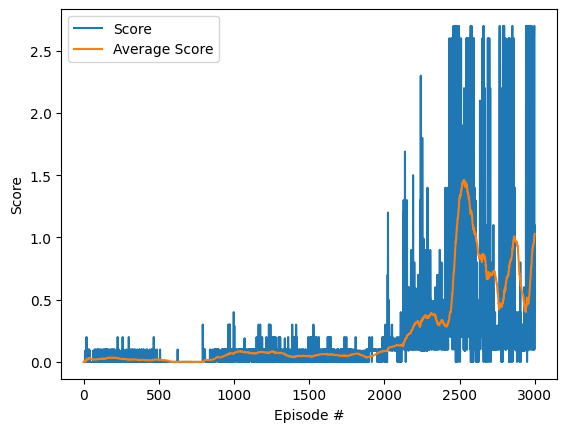

In [15]:
# Plot and save scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_max_hist) + 1), scores_max_hist, label='Score')
plt.plot(np.arange(1, len(scores_mean_hist) + 1), scores_mean_hist, label='Average Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.savefig('scores_plot.png')
plt.show()

In [16]:
# Close the environment
env.close()